#Loading

In [1]:
from google.colab import drive
import pandas as pd
import json
import torch
import torchvision
import re
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
new_mapped_crops_df = pd.read_csv('/content/drive/MyDrive/Project/mapped_crops_table_full.csv')

In [3]:
#sorting entries alphabetically by their crop path so that entries in the same or similar folders are near to eachother
#making image loading from google drive more efficient

def sort_by_letters(df, column_name):
  """
  Sorts a DataFrame by the letters in a specified column, ignoring special characters and considering case.

  Args:
      df (pandas.DataFrame): The DataFrame to sort.
      column_name (str, optional): The name of the column to sort by. Defaults to 'SourceFile'.

  Returns:
      pandas.DataFrame: The sorted DataFrame.
  """

  def remove_special_chars(text):
    return re.sub(r"[^\w\s]", "", text)  # Remove non-alphanumeric characters

  df['SortKey'] = df[column_name].apply(remove_special_chars).str.lower()
  sorted_df = df.sort_values(by='SortKey').drop('SortKey', axis=1)
  return sorted_df

In [4]:
new_sorted_mapped_crops_df = sort_by_letters(new_mapped_crops_df, 'crop_path')

print(len(new_sorted_mapped_crops_df))

new_sorted_mapped_crops_df.head()

107988


,SourceFile,PlaceID,Subject,Date,Time,crop_path,md_conf
37764,/content/drive/MyDrive/Project/Hampstead Heath...,124.0,human,2021:05:19,12:22:31,/content/drive/MyDrive/Project/cropped_images_...,0.410
37266,/content/drive/MyDrive/Project/Hampstead Heath...,124.0,human,2021:05:19,12:22:56,/content/drive/MyDrive/Project/cropped_images_...,0.653
37147,/content/drive/MyDrive/Project/Hampstead Heath...,124.0,human,2021:05:19,12:22:57,/content/drive/MyDrive/Project/cropped_images_...,0.511
37927,/content/drive/MyDrive/Project/Hampstead Heath...,124.0,human,2021:05:19,12:23:06,/content/drive/MyDrive/Project/cropped_images_...,0.745
37314,/content/drive/MyDrive/Project/Hampstead Heath...,124.0,human,2021:05:19,12:23:07,/content/drive/MyDrive/Project/cropped_images_...,0.406


In [5]:
new_sorted_mapped_crops_df = new_sorted_mapped_crops_df[new_sorted_mapped_crops_df['Subject'] != 'human']

print(len(new_sorted_mapped_crops_df))

107799


#File path editing



In [6]:
new_sorted_mapped_crops_df.iloc[1,5]

'/content/drive/MyDrive/Project/cropped_images_new//content/drive/MyDrive/Project/Hampstead Heath 2021/124to136/124_1_HH_2021_14_6_21_9days/100_BTCF/IMG_0477.JPG___crop00_md_v5a.0.0.pt.jpg'

In [7]:
new_sorted_mapped_crops_df.iloc[:,5] = new_sorted_mapped_crops_df.iloc[:,5].str.replace('/drive/MyDrive/Project', '')

new_sorted_mapped_crops_df.iloc[:,5] = new_sorted_mapped_crops_df.iloc[:,5].str.replace('//', '/')

new_sorted_mapped_crops_df.iloc[:,5] = new_sorted_mapped_crops_df.iloc[:,5].str.replace('new/content', 'new')

In [8]:
new_sorted_mapped_crops_df.iloc[1,5]

'/content/cropped_images_new/Hampstead Heath 2021/124to136/124_1_HH_2021_14_6_21_9days/100_BTCF/IMG_0477.JPG___crop00_md_v5a.0.0.pt.jpg'

#Train/Test/Val splits

#Whole dataset

In [ ]:
PlaceID_counts = new_sorted_mapped_crops_df['PlaceID'].value_counts()
print(len(PlaceID_counts))

119


In [ ]:
import matplotlib.pyplot as plt

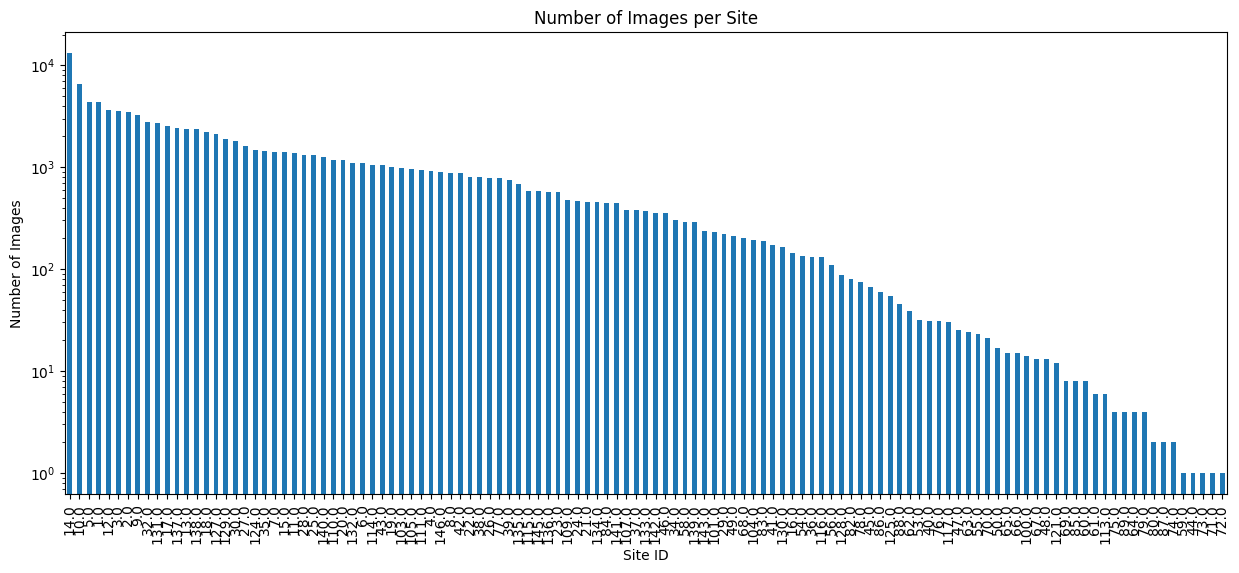

In [ ]:
# Plotting
plt.figure(figsize=(15, 6))
PlaceID_counts.plot(kind='bar')
plt.title('Number of Images per Site')
plt.xlabel('Site ID')
plt.ylabel('Number of Images')
plt.yscale('log')
plt.show()

**Selecting unseen sites for test set so that the unseen sites are around 20% of total sites and their images comprise around 10% of the whole dataset**

In [ ]:
print(PlaceID_counts[45.0])

67


In [ ]:
import numpy as np

def find_subset(PlaceID_counts):
    while True:
        # Randomly select 20 sites
        selected_sites = np.random.choice(PlaceID_counts.index, size=20, replace=False)

        # Calculate total number of images in the selected sites
        total_images = PlaceID_counts[selected_sites].sum()

        # Check if the total number of images falls within the desired range
        if 10000 <= total_images <= 15000:
            return selected_sites

# Assuming PlaceID_counts is your pandas Series with site IDs as index and image counts as values

# Find a subset of 20 sites with the desired total number of images
selected_sites = find_subset(PlaceID_counts)

print("Selected Sites:")
print(selected_sites)
print("Total Number of Images:", PlaceID_counts[selected_sites].sum())


Selected Sites:
[ 40.  44. 100.  45. 101. 137.  59.  41. 128.  17. 132.  74.  73.   5.
  70. 109.  21.  55.  80. 125.]
Total Number of Images: 12056


Selected Sites:
[ 40.  44. 100.  45. 101. 137.  59.  41. 128.  17. 132.  74.  73.   5.
  70. 109.  21.  55.  80. 125.]
Total Number of Images: 12056

In [ ]:
# Create a DataFrame of selected sites
unseen_testing_df = new_sorted_mapped_crops_df[new_sorted_mapped_crops_df['PlaceID'].isin(selected_sites)]

# Remove rows corresponding to selected sites from the original DataFrame
new_sorted_mapped_crops_df = new_sorted_mapped_crops_df[~new_sorted_mapped_crops_df['PlaceID'].isin(selected_sites)]

print(len(new_sorted_mapped_crops_df))
print(len(unseen_testing_df))

95743
12056


In [ ]:
from sklearn.model_selection import train_test_split

# Define test size
test_size = 0.1  # Test size now 0.1 as other 0.1 comes from the unseen sites that have already been removed from the df

# Stratified split by Species for balanced representation
train_val_df, test_df = train_test_split(new_sorted_mapped_crops_df, test_size=test_size, stratify=new_sorted_mapped_crops_df['Subject'], random_state=42)

# Further split train/val (adjust validation size as needed)
val_size = 0.2  # 20% of train_val for validation
train_df, val_df = train_test_split(train_val_df, test_size=val_size, stratify=train_val_df['Subject'], random_state=42)

# Add split column
unseen_testing_df['split'] = 'test' #including the unseen test data in the whole df
train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

# Combine DataFrames (optional, use individual DataFrames for training)
new_all_data_df = pd.concat([train_df, val_df, test_df, unseen_testing_df])

In [ ]:
print(len(new_all_data_df))

107799


In [ ]:
new_all_data_df.to_csv('/content/drive/MyDrive/Project/new_all_data.csv')

In [ ]:
universal_train_set = pd.concat([test_df, unseen_testing_df])

print(len(universal_train_set))

universal_train_set.head()

21631


,SourceFile,PlaceID,Subject,Date,Time,crop_path,md_conf,split
15957,/content/drive/MyDrive/Project/NetworkRail22/C...,10.0,fox,2022:05:18,06:11:02,/content/cropped_images_new/NetworkRail22/Crof...,0.969,test
42855,/content/drive/MyDrive/Project/Hampstead Heath...,131.0,rabbit,2021:05:22,19:17:49,/content/cropped_images_new/Hampstead Heath 20...,0.962,test
93180,/content/drive/MyDrive/Project/Hampstead Heath...,43.0,mouse,2021:05:31,00:48:03,/content/cropped_images_new/Hampstead Heath 20...,0.504,test
6756,/content/drive/MyDrive/Project/NetworkRail22/B...,2.0,squirrel,2022:03:14,10:35:32,/content/cropped_images_new/NetworkRail22/Buck...,0.939,test
42304,/content/drive/MyDrive/Project/Hampstead Heath...,129.0,woodpigeon,2021:06:07,18:21:52,/content/cropped_images_new/Hampstead Heath 20...,0.928,test


In [ ]:
universal_train_set.to_csv('/content/drive/MyDrive/Project/universal_train_set.csv')

In [ ]:
#changing name to universal test set on drive

21631


#Undersampling

In [10]:
new_all_data_df = pd.read_csv('/content/drive/MyDrive/Project/new_all_data.csv')

new_all_data_df.head()

,Unnamed: 0,SourceFile,PlaceID,Subject,Date,Time,crop_path,md_conf,split
0,92013,/content/drive/MyDrive/Project/Hampstead Heath...,39.0,mouse,2021:07:14,00:30:02,/content/cropped_images_new/Hampstead Heath 20...,0.582,train
1,91639,/content/drive/MyDrive/Project/Hampstead Heath...,39.0,squirrel,2021:07:08,16:03:01,/content/cropped_images_new/Hampstead Heath 20...,0.890,train
2,70576,/content/drive/MyDrive/Project/Hampstead Heath...,12.0,fox,2021:05:27,00:15:32,/content/cropped_images_new/Hampstead Heath 20...,0.971,train
3,94369,/content/drive/MyDrive/Project/Hampstead Heath...,46.0,robin,2021:08:12,15:26:18,/content/cropped_images_new/Hampstead Heath 20...,0.926,train
4,24107,/content/drive/MyDrive/Project/NetworkRail22/H...,14.0,squirrel,2022:04:02,08:35:28,/content/cropped_images_new/NetworkRail22/Hith...,0.957,train


In [11]:
species_counts = new_all_data_df['Subject'].value_counts()

print(species_counts)

Subject
fox                31114
squirrel           23251
dog                19261
mouse               5022
rat                 4094
woodpigeon          4007
magpie              2848
cat                 2713
crow                2436
robin               2271
blackbird           1844
badger              1497
muntjac             1178
songthrush          1160
hedgehog            1113
moorhen              976
rabbit               778
jay                  743
thrush               409
dunnock              272
rockdove             149
redwing              143
willowwarbler        140
greattit             122
mallard              118
wren                 108
greenwoodpecker       32
Name: count, dtype: int64


In [12]:
#undersampling function

def undersample_dataframe(df, column_name, max_entries_per_class):
    # Calculate class frequencies
    class_counts = df[column_name].value_counts()

    # Initialize an empty list to store undersampled DataFrames for each class
    undersampled_dfs = []

    # Iterate over each unique class
    for class_label, count in class_counts.items():
        # If the class has more entries than the maximum allowed, perform undersampling
        if count > max_entries_per_class:
            # Subset the DataFrame for the current class and sample randomly to get max_entries_per_class samples
            undersampled_df_class = df[df[column_name] == class_label].sample(n=max_entries_per_class, replace=False)

            # Append the undersampled DataFrame for the current class to the list
            undersampled_dfs.append(undersampled_df_class)
        else:
            # If the class has fewer or equal entries than the maximum allowed, keep all entries
            undersampled_dfs.append(df[df[column_name] == class_label])

    # Concatenate the undersampled DataFrames for all classes to form the final undersampled DataFrame
    undersampled_df = pd.concat(undersampled_dfs)

    return undersampled_df

Taking only train set

In [13]:
training_df = new_all_data_df[new_all_data_df['split'] == 'train']

Test and Val df

In [15]:
test_val_df = new_all_data_df[(new_all_data_df['split'] == 'val') | (new_all_data_df['split'] == 'test')]

In [14]:
species_counts = training_df['Subject'].value_counts()

print(species_counts)

Subject
fox                20839
squirrel           15174
dog                11630
mouse               2907
rat                 2705
woodpigeon          2518
cat                 1909
magpie              1796
robin               1501
blackbird           1230
crow                 985
badger               978
hedgehog             742
songthrush           739
muntjac              731
moorhen              582
rabbit               492
jay                  470
thrush               254
dunnock              196
redwing              103
rockdove              99
willowwarbler         98
greattit              87
wren                  77
mallard               69
greenwoodpecker       23
Name: count, dtype: int64


#Undersampling training set only

**Undersample1**

In [16]:
undersample1 = undersample_dataframe(training_df, 'Subject', 10000)

In [ ]:
full_undersample1 = pd.concat([undersample1, test_val_df])

In [ ]:
#class frequencies of training set

species_counts = undersample1['Subject'].value_counts()

print(species_counts)

In [36]:
full_undersample1.to_csv('/content/drive/MyDrive/Project/undersample1.csv', index=False)

**Undersample2**

In [27]:
undersample2 = undersample_dataframe(training_df, 'Subject', 5000)

In [28]:
full_undersample2 = pd.concat([undersample2, test_val_df])

In [37]:
full_undersample2.to_csv('/content/drive/MyDrive/Project/undersample2.csv', index=False)

**Undersample3**

In [30]:
undersample3 = undersample_dataframe(training_df, 'Subject', 3000)

In [31]:
full_undersample3 = pd.concat([undersample3, test_val_df])

In [38]:
full_undersample3.to_csv('/content/drive/MyDrive/Project/undersample3.csv', index=False)

**Gini index to measure class imbalance of dataset**

In [24]:
import numpy as np

def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [25]:
species_counts = new_all_data_df['Subject'].value_counts()

counts_list = []

for label, count in species_counts.items():
  counts_list.append(count)

gini_index = gini(counts_list)

print(f'Gini index: {gini_index}')

Gini index: 0.729714733147047


In [26]:
species_counts = undersample1['Subject'].value_counts()

counts_list = []

for label, count in species_counts.items():
  counts_list.append(count)

gini_index = gini(counts_list)

print(f'Gini index: {gini_index}')

Gini index: 0.6684300256271947


In [29]:
species_counts = undersample2['Subject'].value_counts()

counts_list = []

for label, count in species_counts.items():
  counts_list.append(count)

gini_index = gini(counts_list)

print(f'Gini index: {gini_index}')

Gini index: 0.5773087297432177


In [32]:
species_counts = undersample3['Subject'].value_counts()

counts_list = []

for label, count in species_counts.items():
  counts_list.append(count)

gini_index = gini(counts_list)

print(f'Gini index: {gini_index}')

Gini index: 0.5155913564351715
